<a href="https://colab.research.google.com/github/iqbalparekh97/DeepLearning/blob/main/BirdOrNotBird_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install duckduckgo_search
!pip install fastai

##Step 1: Download images of Birds and Non-Birds

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [9]:
##Searching images from duckduckgo.com
from IPython.display import Image
urls = search_images('bird photos', max_images=1)


Searching for 'bird photos'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


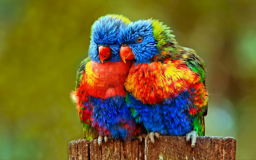

In [10]:
##Displaying the image on Jupyter Notebook
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)


Searching for 'forest photos'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


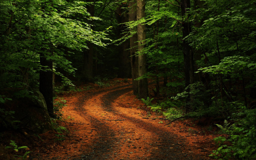

In [11]:
##Now, we'll do the same for forest photos
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [12]:
##Since our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos,
## and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


##Step 2: Train Our Model

In [13]:
##Removing photos that might not have downloaded correctly and could cause the model to fail
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


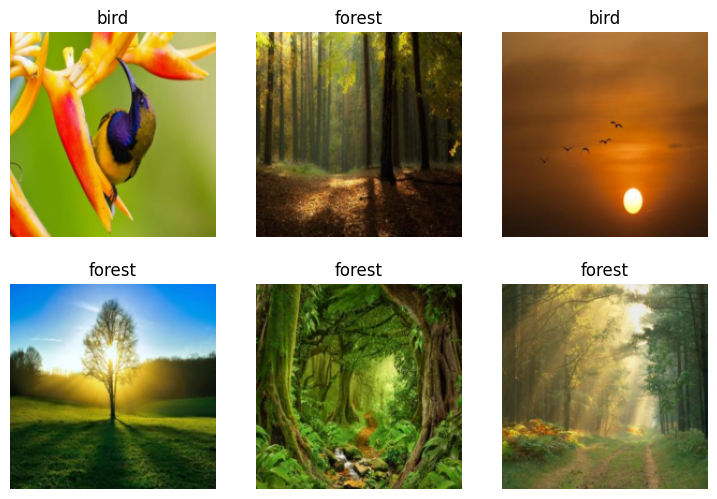

In [14]:
##To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model)
## and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [15]:
##Training our model. The fastest widely used computer vision model is resnet18.
## fastai's fine_tune() method will automatically uses best practices for fine tuning a pre-trained model, so we'll use that

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 42.5MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.842153,1.132130,0.354839,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.240471,0.442470,0.129032,00:24
1,0.148035,0.173591,0.096774,00:30
2,0.122950,0.095657,0.064516,00:26


In [16]:
##Checking the first image that we displayed to see if our model recognizes it or not
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9982
